# Iris - Logistic Regression
This example applies Logistic Regression in order to predict the type of iris plant based on sepal and petal length and width.

## Import some useful libraries and get Spark Context

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sc= SparkContext()
sqlContext = SQLContext(sc)

## Load the database, convert it to Spark and split data into train and test sets

[Iris Data Set](https://archive.ics.uci.edu/ml/datasets/iris)

Attribute Information:
 	
- sepal length in cm
- sepal width in cm
- petal length in cm
- petal width in cm
- class:
    - Iris-Setosa
    - Iris-Versicolour
    - Iris-Virginica

In [2]:
pdf = pd.read_csv('iris.data')
pdf.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
data = sqlContext.createDataFrame(pdf)
pdf.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


In [16]:
pdf.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object

In [19]:
pdf.species = pdf.species.astype('category')
pdf.dtypes

sepal_length     float64
sepal_width      float64
petal_length     float64
petal_width      float64
species         category
species_cat         int8
dtype: object

In [20]:
pdf["species_cat"] = pdf.species.cat.codes
pdf.head()

,sepal_length,sepal_width,petal_length,petal_width,species,species_cat
0,4.9,3.0,1.4,0.2,Iris-setosa,0
1,4.7,3.2,1.3,0.2,Iris-setosa,0
2,4.6,3.1,1.5,0.2,Iris-setosa,0
3,5.0,3.6,1.4,0.2,Iris-setosa,0
4,5.4,3.9,1.7,0.4,Iris-setosa,0


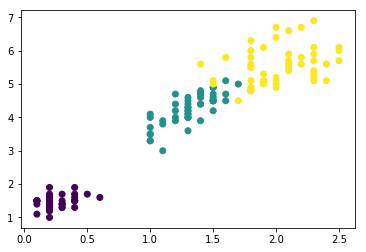

In [25]:
length = pdf.petal_length # use only 'sepal length and sepal width'
width = pdf.petal_width
y_iris = pdf.species_cat
plt.scatter(width, length, c=y_iris)

In [37]:
X = pdf.filter(['petal_length','petal_width'], axis=1) # use only 'sepal length and sepal width'
y = pdf.species_cat
X.head()

,petal_length,petal_width
0,1.4,0.2
1,1.3,0.2
2,1.5,0.2
3,1.4,0.2
4,1.7,0.4


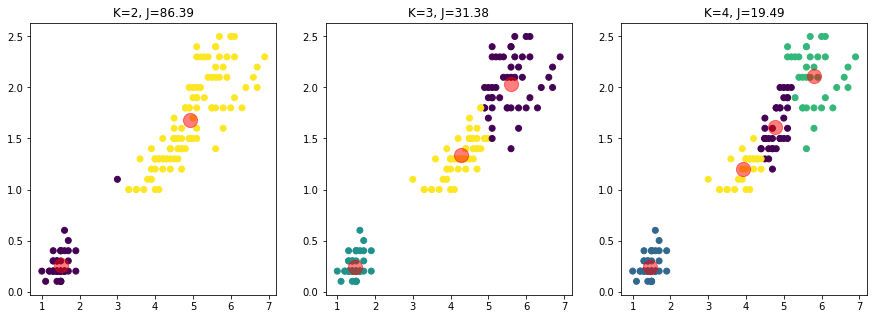

In [39]:
from sklearn import cluster, datasets

km2 = cluster.KMeans(n_clusters=2).fit(X)
km3 = cluster.KMeans(n_clusters=3).fit(X)
km4 = cluster.KMeans(n_clusters=4).fit(X)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.scatter(X.petal_length, X.petal_width, c=km2.labels_)
plt.title("K=2, J=%.2f" % km2.inertia_)
c2 = km2.cluster_centers_
plt.scatter(c2[:, 0], c2[:, 1], c='red', s=200, alpha=0.5);

plt.subplot(132)
plt.scatter(X.petal_length, X.petal_width, c=km3.labels_)
plt.title("K=3, J=%.2f" % km3.inertia_)
c3 = km3.cluster_centers_
plt.scatter(c3[:, 0], c3[:, 1], c='red', s=200, alpha=0.5);

plt.subplot(133)
plt.scatter(X.petal_length, X.petal_width, c=km4.labels_)
plt.title("K=4, J=%.2f" % km4.inertia_)
c4 = km4.cluster_centers_
plt.scatter(c4[:, 0], c4[:, 1], c='red', s=200, alpha=0.5);

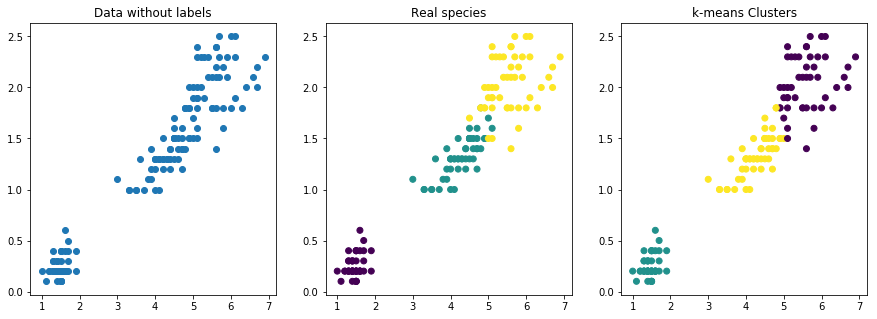

In [40]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Data without labels")
plt.scatter(X.petal_length, X.petal_width)

plt.subplot(132)
plt.title("Real species")
plt.scatter(X.petal_length, X.petal_width, c=y)

plt.subplot(133)
plt.title("k-means Clusters")
plt.scatter(X.petal_length, X.petal_width, c=km3.labels_)

In [62]:
df = sqlContext.createDataFrame(pdf)
df.show(3)

+------------+-----------+------------+-----------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    species|species_cat|
+------------+-----------+------------+-----------+-----------+-----------+
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|          0|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|          0|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|          0|
+------------+-----------+------------+-----------+-----------+-----------+
only showing top 3 rows



In [63]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = ['sepal_length', "sepal_width", "petal_length", "petal_width"], outputCol = 'features')
df = vectorAssembler.transform(df)
df.show(3)

+------------+-----------+------------+-----------+-----------+-----------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|    species|species_cat|         features|
+------------+-----------+------------+-----------+-----------+-----------+-----------------+
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|          0|[4.9,3.0,1.4,0.2]|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|          0|[4.7,3.2,1.3,0.2]|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|          0|[4.6,3.1,1.5,0.2]|
+------------+-----------+------------+-----------+-----------+-----------+-----------------+
only showing top 3 rows



In [65]:
from pyspark.sql.functions import col

dataS = df.select(['features'])
dataS.show()

+-----------------+
|         features|
+-----------------+
|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|
|[5.4,3.9,1.7,0.4]|
|[4.6,3.4,1.4,0.3]|
|[5.0,3.4,1.5,0.2]|
|[4.4,2.9,1.4,0.2]|
|[4.9,3.1,1.5,0.1]|
|[5.4,3.7,1.5,0.2]|
|[4.8,3.4,1.6,0.2]|
|[4.8,3.0,1.4,0.1]|
|[4.3,3.0,1.1,0.1]|
|[5.8,4.0,1.2,0.2]|
|[5.7,4.4,1.5,0.4]|
|[5.4,3.9,1.3,0.4]|
|[5.1,3.5,1.4,0.3]|
|[5.7,3.8,1.7,0.3]|
|[5.1,3.8,1.5,0.3]|
|[5.4,3.4,1.7,0.2]|
+-----------------+
only showing top 20 rows



In [86]:
from pyspark.ml.clustering import KMeans

k_means_2 = KMeans(featuresCol='features', k=2)
model_k2 = k_means_2.fit(dataS)

k_means_3 = KMeans(featuresCol = 'features', k=3)
model_k3 = k_means_3.fit(dataS)

k_means_4 = KMeans(featuresCol = 'features', k=4)
model_k4 = k_means_4.fit(dataS)

In [83]:
model_k2_data = model_k2.transform(dataS)
model_k2_data.show(5)
model_k2_data.groupBy('prediction').count().show()

+-----------------+----------+
|         features|prediction|
+-----------------+----------+
|[4.9,3.0,1.4,0.2]|         0|
|[4.7,3.2,1.3,0.2]|         0|
|[4.6,3.1,1.5,0.2]|         0|
|[5.0,3.6,1.4,0.2]|         0|
|[5.4,3.9,1.7,0.4]|         0|
+-----------------+----------+
only showing top 5 rows

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   97|
|         0|   52|
+----------+-----+



In [84]:
model_k3_data = model_k3.transform(dataS)
model_k3_data.show(5)
model_k3_data.groupBy('prediction').count().show()

+-----------------+----------+
|         features|prediction|
+-----------------+----------+
|[4.9,3.0,1.4,0.2]|         0|
|[4.7,3.2,1.3,0.2]|         0|
|[4.6,3.1,1.5,0.2]|         0|
|[5.0,3.6,1.4,0.2]|         0|
|[5.4,3.9,1.7,0.4]|         0|
+-----------------+----------+
only showing top 5 rows

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   62|
|         2|   38|
|         0|   49|
+----------+-----+



In [87]:
model_k4_data = model_k4.transform(dataS)
model_k4_data.show(5)
model_k4_data.groupBy('prediction').count().show()

+-----------------+----------+
|         features|prediction|
+-----------------+----------+
|[4.9,3.0,1.4,0.2]|         0|
|[4.7,3.2,1.3,0.2]|         0|
|[4.6,3.1,1.5,0.2]|         0|
|[5.0,3.6,1.4,0.2]|         0|
|[5.4,3.9,1.7,0.4]|         0|
+-----------------+----------+
only showing top 5 rows

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   46|
|         3|   26|
|         2|   28|
|         0|   49|
+----------+-----+

